# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import seaborn as sns
import time

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", 10000)

In [3]:
df=pd.read_excel('geo.xlsx')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


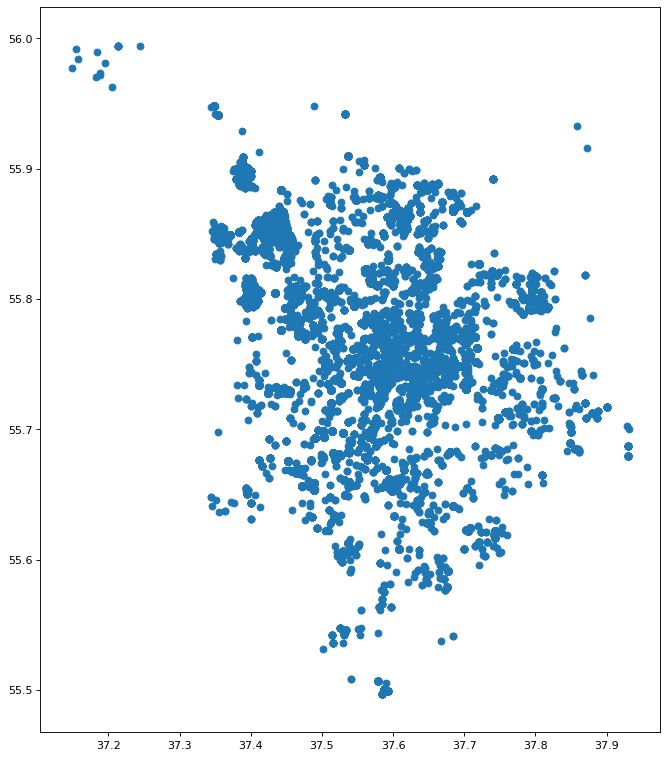

In [4]:
plt.figure(figsize=(10,12), dpi=80)
plt.scatter(df.x,df.y)

Разобьем по районам без комментариев.

In [33]:
X = np.array([np.array(df.x),np.array(df.y)]).reshape(2,-1).T
X = StandardScaler().fit_transform(X)

default_base = {'quantile': .09, 'eps': .09, 'damping': .75, 'preference': -220, 'n_neighbors': 10, 
                'n_clusters': 130, 'min_samples': 20, 'xi': 0.05, 'min_cluster_size': 0.2,
                'threshold':0.05}

params = default_base.copy()

In [17]:
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], 
                                      eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], 
                        min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
birch = cluster.Birch(threshold=params['threshold'], n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
#        ('AffinityPropagation', affinity_propagation),
#        ('SpectralClustering', spectral),
        ('DBSCAN', dbscan),
#        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

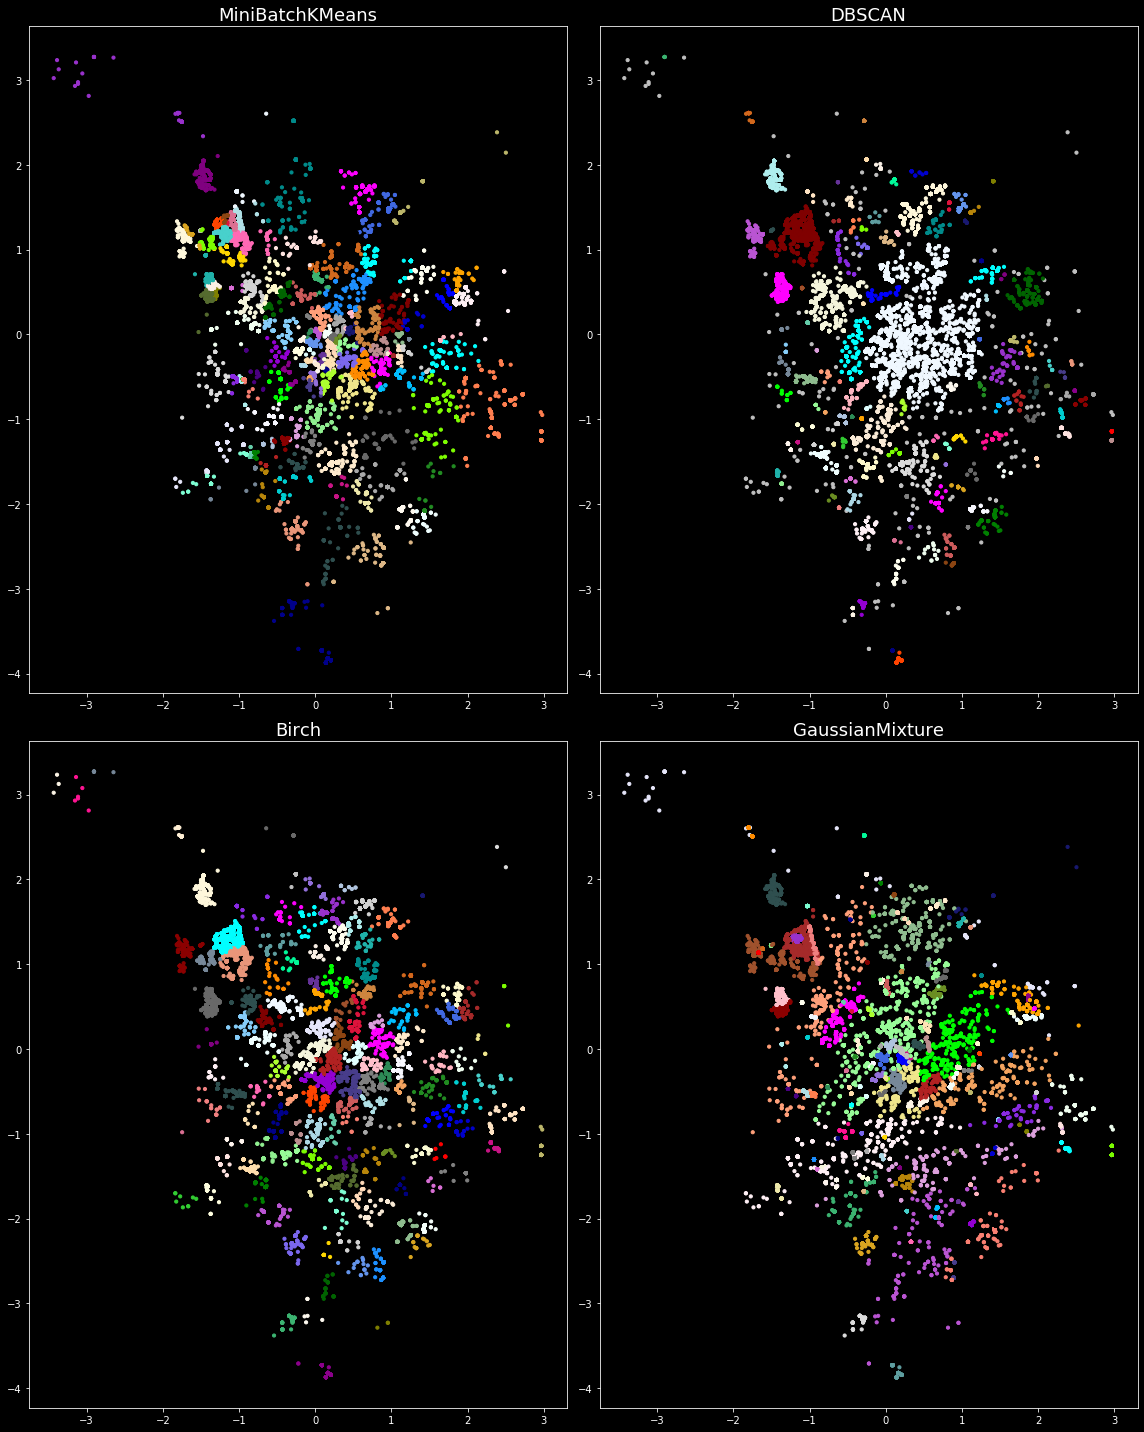

In [22]:
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(16,20))

for i, (name, algorithm) in enumerate(clustering_algorithms):
    y_pred = algorithm.fit_predict(X)
    colors = np.array(list(islice(cycle(mcolors.CSS4_COLORS.values()),int(max(y_pred) + 1))))
    plt.style.use('dark_background')
    axes[int(i/2),i%2].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    axes[int(i/2),i%2].set_title(name, size=18)

fig.tight_layout()

На предыдущих рисунках видно, что DBSCAN выделяет определенные районы по плотностям. В особенности, Куркино, Тушино, Митино, Строгино - в этих районах самая большая активность комментирования.

Рассмотрим две выборки с положительными и отрицательными комментариями.

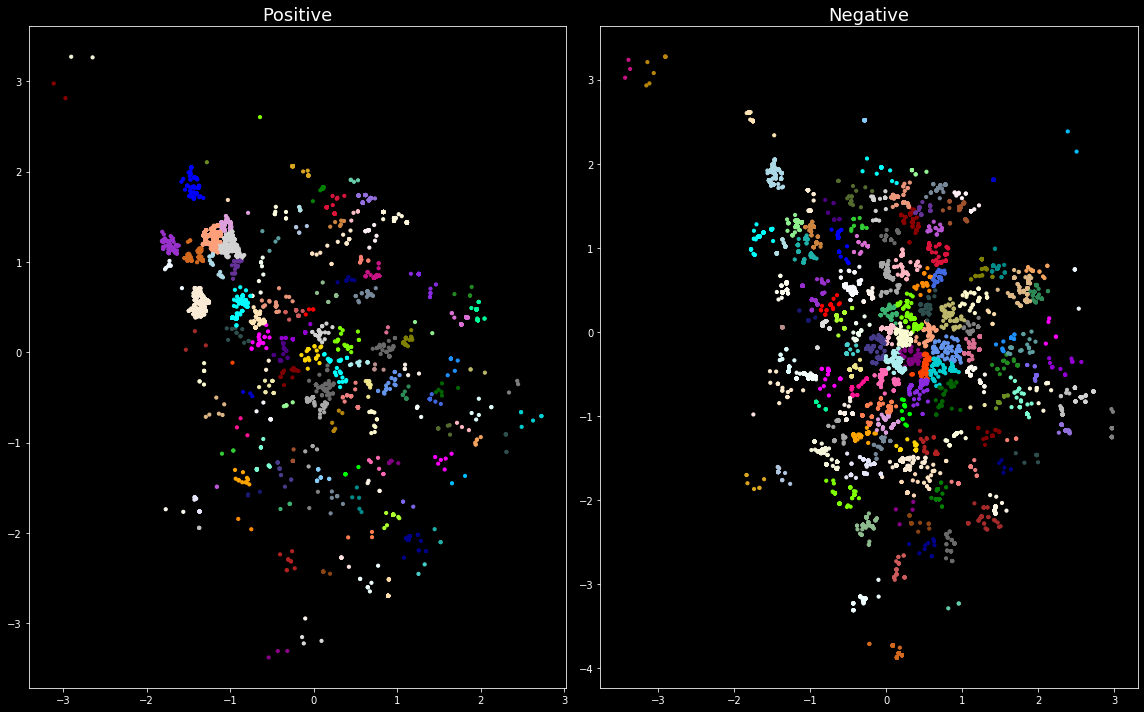

In [32]:
Xo = np.array([np.array(df.x),np.array(df.y)]).reshape(2,-1).T
Xp = np.array([np.array(df[df.comment_class==1].x),np.array(df[df.comment_class==1].y)]).reshape(2,-1).T
Xn = np.array([np.array(df[df.comment_class==-1].x),np.array(df[df.comment_class==-1].y)]).reshape(2,-1).T

ssc = StandardScaler()
ssc.fit(Xo)
Xp = ssc.transform(Xp)
Xn = ssc.transform(Xn)

y_pred_p=birch.fit_predict(Xp)
y_pred_n=birch.fit_predict(Xn)

fig,axes=plt.subplots(ncols=2,nrows=1,figsize=(16,10))
colors = np.array(list(islice(cycle(mcolors.CSS4_COLORS.values()),int(max(y_pred_p) + 1))))
axes[0].scatter(Xp[:, 0], Xp[:, 1], s=10, color=colors[y_pred_p])
axes[0].set_title('Positive', size=18)
colors = np.array(list(islice(cycle(mcolors.CSS4_COLORS.values()),int(max(y_pred_n) + 1))))
axes[1].scatter(Xn[:, 0], Xn[:, 1], s=10, color=colors[y_pred_n])
axes[1].set_title('Negative', size=18)

fig.tight_layout()

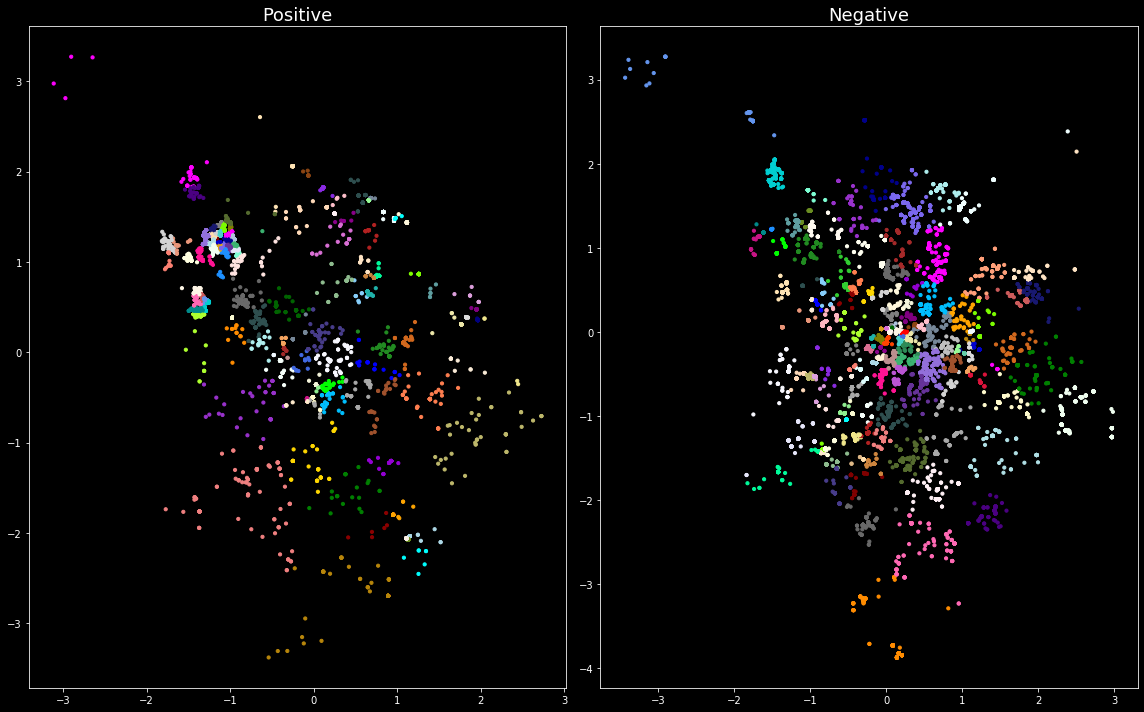

In [31]:
Xo = np.array([np.array(df.x),np.array(df.y)]).reshape(2,-1).T
Xp = np.array([np.array(df[df.comment_class==1].x),np.array(df[df.comment_class==1].y)]).reshape(2,-1).T
Xn = np.array([np.array(df[df.comment_class==-1].x),np.array(df[df.comment_class==-1].y)]).reshape(2,-1).T

ssc = StandardScaler()
ssc.fit(Xo)
Xp = ssc.transform(Xp)
Xn = ssc.transform(Xn)

y_pred_p=two_means.fit_predict(Xp)
y_pred_n=two_means.fit_predict(Xn)

fig,axes=plt.subplots(ncols=2,nrows=1,figsize=(16,10))
colors = np.array(list(islice(cycle(mcolors.CSS4_COLORS.values()),int(max(y_pred_p) + 1))))
axes[0].scatter(Xp[:, 0], Xp[:, 1], s=10, color=colors[y_pred_p])
axes[0].set_title('Positive', size=18)
colors = np.array(list(islice(cycle(mcolors.CSS4_COLORS.values()),int(max(y_pred_n) + 1))))
axes[1].scatter(Xn[:, 0], Xn[:, 1], s=10, color=colors[y_pred_n])
axes[1].set_title('Negative', size=18)

fig.tight_layout()

Сколько кластеров оптимально?

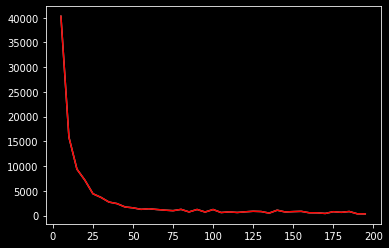

In [53]:
k_inertia = []
ks = range(5,200,5)

for k in ks:
    clf_mbkm = cluster.MiniBatchKMeans(n_clusters=k)
    clusters_mbkm = clf_mbkm.fit_predict(X)
    k_inertia.append(clf_mbkm.inertia_)
    
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'r')
plt.show()

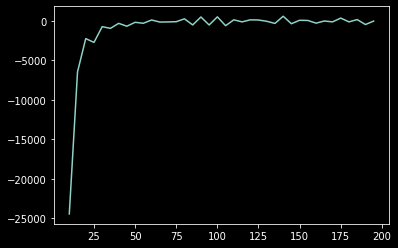

In [54]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)
plt.show()

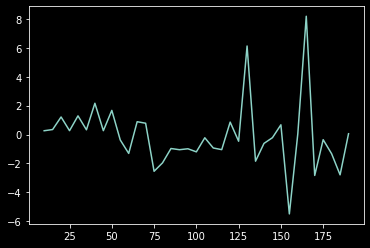

In [55]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)
plt.show()

In [56]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

155